# Black-Schols Model 
### Aplications *Microsoft - Call Options*

We need the currend stock price, exercise price (strike price), time (in years) to expiration date. Those data we can find in Yahoo! finance. For Microsoft's call option. We found the allowing data:

[MSFT210528C00170000] This is the contract name. 

Today is 28/04/2021, while the expirated day: 28/05/2021, this mean time to expiration is 30 days. We have to pass (convert) to years, a year has 365 days, then time to expiration (in years) is 30/365.

Strike price is 170 , currend stock price is 254.35 

Only we need to find two values to calculate the value of call, variance and risk-free rate. To this we will need to install and import a package: **pandas-datareader**


!pip install pandas-datareader
import pandas_datareader as pdr

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
 # for style: is optional
import qeds
qeds.themes.mpl_style(); 

In [2]:
MSFT = pdr.data.DataReader("MSFT",
                           start='2000-1-1',
                           end= '2020-12-20',
                           data_source='yahoo')
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5276 entries, 2000-01-03 to 2020-12-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5276 non-null   float64
 1   Low        5276 non-null   float64
 2   Open       5276 non-null   float64
 3   Close      5276 non-null   float64
 4   Volume     5276 non-null   float64
 5   Adj Close  5276 non-null   float64
dtypes: float64(6)
memory usage: 288.5 KB


We import time series of stock price of Microsoft. 

Period: daily
variable: Adjusted Close

The sample periods (historical): '2000/01/03' : '2020/12/18'

We need to resample by year to get yearly return

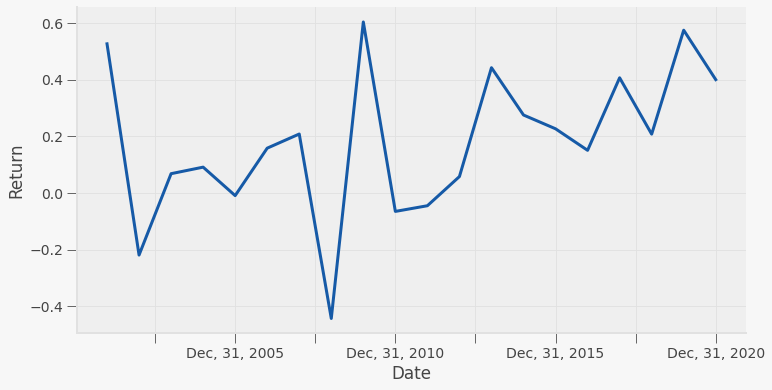

In [3]:
MSFT_close_year = MSFT['Adj Close'].resample('1Y').agg(lambda x: x.tail(1))
MSFT_close_year_return = MSFT_close_year.pct_change()
MSFT_close_year_return.index = MSFT_close_year_return.index.strftime('%b, %d, %Y')
ax = MSFT_close_year_return.plot(figsize=(12, 6), lw=3)
ax.set_ylabel('Return')
plt.show()

Then, we convert to continuous composed

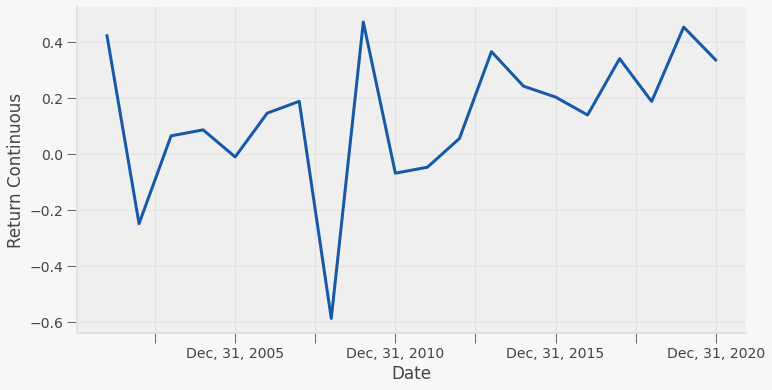

In [4]:
MSFT_close_year_return_continuous = np.log(1 + MSFT_close_year_return)
ax = MSFT_close_year_return_continuous.plot(figsize=(12, 6), lw=3)
ax.set_ylabel('Return Continuous')
plt.show()

In [5]:
# the variance of continuous return on the stock 

MSFT_close_year_return_continuous.var() 

0.06498668659078763

Now, only we need the risk-free rate.

This is the link where we can find the risk-free rate daily.
https://ycharts.com/indicators/1_year_treasury_rate

The max 1 Year Treasury Rate on 2020 was 1.53%, then we use this rate

The allowing step is converting to continuos composed
 
$ r_{continuous} = ln( 1 + r_{1y}) $

In [6]:
r = 0.0153
r_continuous = np.log(1 + r)
r_continuous

0.015184135325040055

We definite the function that calculate the price of call option definte in Black-Schols Model

In [7]:
from scipy import stats
def call_option_price(S, K, t, r, var):
    """
    call_option_price(S, K, t, r, sigma) computes and returns the exact price of a call option 
    of time to maturity 't' and strike price 'K' given the spot price of the underlying asset 'S', 
    the continuosly compounded short-rate 'r' and variance of the 
    underlying asset var.

    Parameters:
        S (float):     spot price of the underlying asset;
        K (float):     strike price;
        t (float):   time to maturity (in years);
        r (float):     continuously compounded short-rate;
        var (float): variance of underlying asset;
        
    Returns:
        price (float): call price;

    """
    
    if S == 0: # this is to avoid log(0) issues
        return 0.0
    elif t == 0: # this is to avoid 0/0 issues
        return call_option_payoff(S, K)
    else:
        d1 = (np.log(S / K) + (r + 0.5 * var) * t) / (np.sqrt(var*t))
        d2 = d1 - np.sqrt(var*t)

        price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * t) * stats.norm.cdf(d2, 0.0, 1.0)

        return price

In [8]:
# to see the parameters

call_option_price?

In [9]:
# r_continuous

S = 254.35
K = 170
R =  r_continuous
var =  MSFT_close_year_return_continuous.var()
t = 30/365

In [10]:
call_option_price(S, K, t, R, var)

84.56202959714759

But the market price is 91.3, what is the error?

The inversors may have adjusted the variance, and this is what we are going to do

How much we need adjusted the variance?

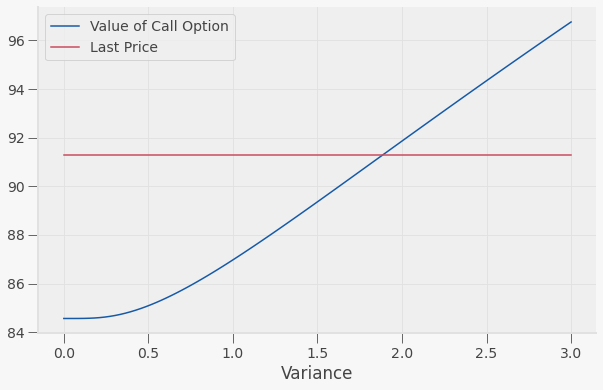

In [11]:
var_s = np.linspace(0, 3, 100)
e = []
for v in var_s:
    e.append(call_option_price(S, K, t, R, var + v))
fig, ax = plt.subplots(figsize=(10, 6))    
ax.plot(var_s, e, label = 'Value of Call Option')
ax.plot(var_s, [91.3]*100, label = 'Last Price')
ax.set_xlabel('Variance')
ax.legend()
plt.show()

We can see the variance must be 1.964(= var + 1.9), and this mean the std must be 140.1%, but the std historical was 25.5%. This mean the expected volatility is 115%. 

Other possible answer to error above is the Microsoft's call opction have been in the money over last year. This increase its demand, then its price.